## Business Goal: Determine which days see the most activity from soccer fans, and whether this is driven by match days.

In [3]:
# Setup - Run only once per Kernel App
# %conda install openjdk -y

# # install PySpark
# %pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [10]:
import pyspark.sql.functions as f
from pyspark.sql.functions import when, min, max, col
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Read in data

In [5]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.executor.memory", "10g")
    .config("spark.driver.memory", "10g")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5ac7075b-59a6-49b5-9768-26d373d8ab8b;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 313ms :: artifacts dl 22ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [6]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=3600,
)

# s3 paths
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_logs = f"spark_logs"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 2.04 s, sys: 164 ms, total: 2.2 s
Wall time: 2.48 s


In [7]:
%%time
df_path = f"reddit_soccer_data/"
s3_path = f"s3a://{bucket}/{df_path}"
print(f"reading submissions from {s3_path}")
df = spark.read.parquet(s3_path, header=True)
print(f"shape of the dataframe is {df.count():,}x{len(df.columns)}")

reading submissions from s3a://sagemaker-us-east-1-634977863454/reddit_soccer_data/


23/12/08 16:11:54 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the dataframe is 5,617,852x9
CPU times: user 44.5 ms, sys: 655 µs, total: 45.2 ms
Wall time: 1min 22s


### Get the count of comments every day

In [8]:
daily_counts = df.withColumn("date", f.to_date("created_utc")).groupBy("date").count().orderBy("date")
daily_counts.show(5)

+----------+-----+
|      date|count|
+----------+-----+
|2023-01-01|56143|
|2023-01-02|63417|
|2023-01-03|69826|
|2023-01-04|66360|
|2023-01-05|61147|
+----------+-----+
only showing top 5 rows



In [13]:
daily_counts_pd = daily_counts.toPandas().sort_values(by="date")
daily_counts_pd['date'] = pd.to_datetime(daily_counts_pd['date'])

# plt.figure(figsize=(20, 12))
# plt.plot(daily_counts_pd['date'], daily_counts_pd['count'], marker='o', color='seagreen')
# plt.title('Daily Activity Count')
# plt.xlabel('Date', fontsize=28)
# plt.ylabel('Number of Posts/Comments', fontsize=28)
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()

# Show the plot
# plt.show()

### Read the data frame for the numbers of top leagues matches played each day

In [14]:
df_schedule = pd.read_csv("./football_schedule.csv")
df_schedule.head()

,Date,PremierLeague,LaLiga,Bundesliga,SerieA,Ligue1,ChampionsLeague
0,1/1/2023,2,0,0,0,6,0
1,1/2/2023,1,0,0,0,4,0
2,1/3/2023,4,0,0,0,0,0
3,1/4/2023,4,0,0,10,0,0
4,1/5/2023,1,0,0,0,0,0


In [15]:
# Data cleaning
df_schedule['date'] = pd.to_datetime(df_schedule['Date'])
df_schedule['date'] = df_schedule['date'].dt.strftime('%Y-%m-%d')
df_schedule['date'] = pd.to_datetime(df_schedule['date'])
df_schedule.drop('Date', axis=1, inplace=True)
cols = ['date'] + [col for col in df_schedule if col != 'date']
df_schedule = df_schedule[cols]
df_schedule['TotalMatches'] = df_schedule.iloc[:, 1:7].sum(axis=1)
df_schedule.head()

,date,PremierLeague,LaLiga,Bundesliga,SerieA,Ligue1,ChampionsLeague,TotalMatches
0,2023-01-01,2,0,0,0,6,0,8
1,2023-01-02,1,0,0,0,4,0,5
2,2023-01-03,4,0,0,0,0,0,4
3,2023-01-04,4,0,0,10,0,0,14
4,2023-01-05,1,0,0,0,0,0,1


### Data Visualizations: explore whether there is a relationship between the daily comments counts and the number of top league matches played

In [16]:
# First, merge the dataframes of the daily comments count and daily matches count
merged_df = pd.merge(daily_counts_pd, df_schedule, on='date', how='outer')
merged_df.fillna(0, inplace=True)

date_range = pd.date_range(start=merged_df['date'].min(), end=merged_df['date'].max())
merged_df.set_index('date', inplace=True)
merged_df = merged_df.reindex(date_range, fill_value=0).reset_index()
merged_df.rename(columns={'index': 'date'}, inplace=True)
merged_df.head()

,date,count,PremierLeague,LaLiga,Bundesliga,SerieA,Ligue1,ChampionsLeague,TotalMatches
0,2023-01-01,56143.0,2,0,0,0,6,0,8
1,2023-01-02,63417.0,1,0,0,0,4,0,5
2,2023-01-03,69826.0,4,0,0,0,0,0,4
3,2023-01-04,66360.0,4,0,0,10,0,0,14
4,2023-01-05,61147.0,1,0,0,0,0,0,1


### Line Chart

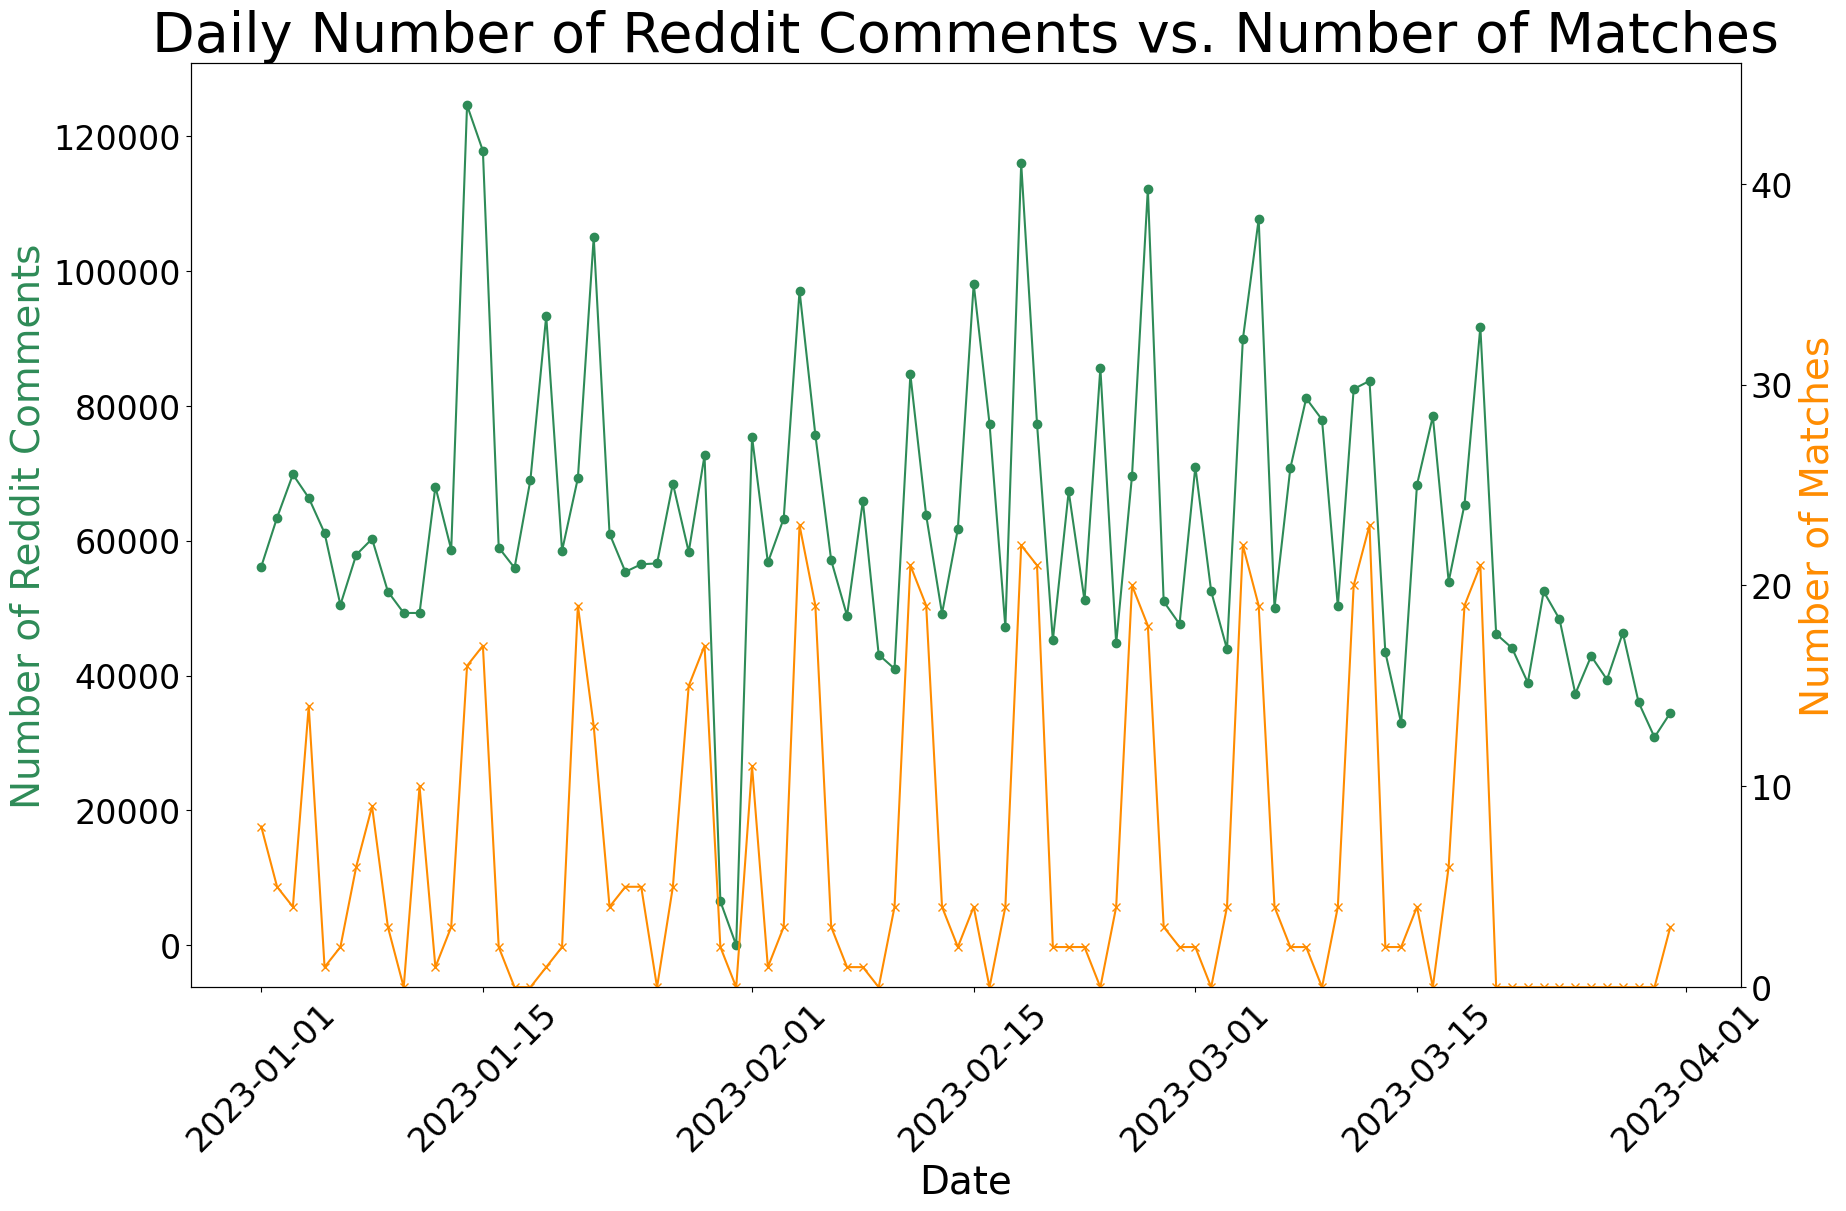

In [17]:
fig, ax1 = plt.subplots(figsize=(20, 12))

# Plot the first data series (Reddit Comments) on ax1
color = 'seagreen'
ax1.set_xlabel('Date', fontsize=28)
ax1.set_ylabel('Number of Reddit Comments', color=color, fontsize=28)
ax1.plot(merged_df['date'], merged_df['count'], label='Reddit Comments', marker='o', color=color)
ax1.tick_params(axis='y', labelsize=24)
ax1.tick_params(axis='x', rotation=45, labelsize=24)

# Create a second y-axis for the second data series (Number of Matches)
ax2 = ax1.twinx()
ax2.set_ylim(0, (merged_df['TotalMatches'].max()) * 2)
color = 'darkorange'
ax2.set_ylabel('Number of Matches', color=color, fontsize=28)
ax2.plot(merged_df['date'], merged_df['TotalMatches'], label='Number of Matches', marker='x', color=color)
ax2.tick_params(axis='y', labelsize=24)

# Title and grid
plt.title('Daily Number of Reddit Comments vs. Number of Matches', fontsize=40)
plt.grid(False)

# Save the plot
# plt.savefig('./Users/hx111/fall-2023-reddit-project-team-08/data/plots/daily_comments_matches.png')

# Show the plot
plt.show()

This line plot shows the pattern of the daily number of Reddit comments in the subreddits about soccer, and the daily number of soccer matches played in top leagues. There are similar traits in the two lines, for example on 2023-01-30 and 2023-01-31 there are few to none matches played, and the comments count on Reddit for these two days are also low; For every few days there are two days where around 20 matches are played, and on these days the number of Reddit comments also peaked. This time series line charts therefore show some degree of correlation between the number of comments and matches for each day.

### Feedback discussion: Professor mentions that to continue down on the track of looking for the correlation, some kind of metric should also be provided. Indeed, to determine if there is a strong correlation between the number of matches and the number of comments for each day, a statistic result should be helpful. So first, the correlation coefficient is calculated, then, a scatter plot with a regression line is also shown.

In [22]:
print("The correlation coefficient between the number of comments and matches each day: ", merged_df['count'].corr(merged_df['TotalMatches']))

The correlation coefficient between the number of comments and matches each day:  0.6141717458352672


Since 0.614 is not a large number, we can say that the two counts are moderately positively correlated. To further explore this, a scatter plot between the two counts along with a regression line is also shown below.

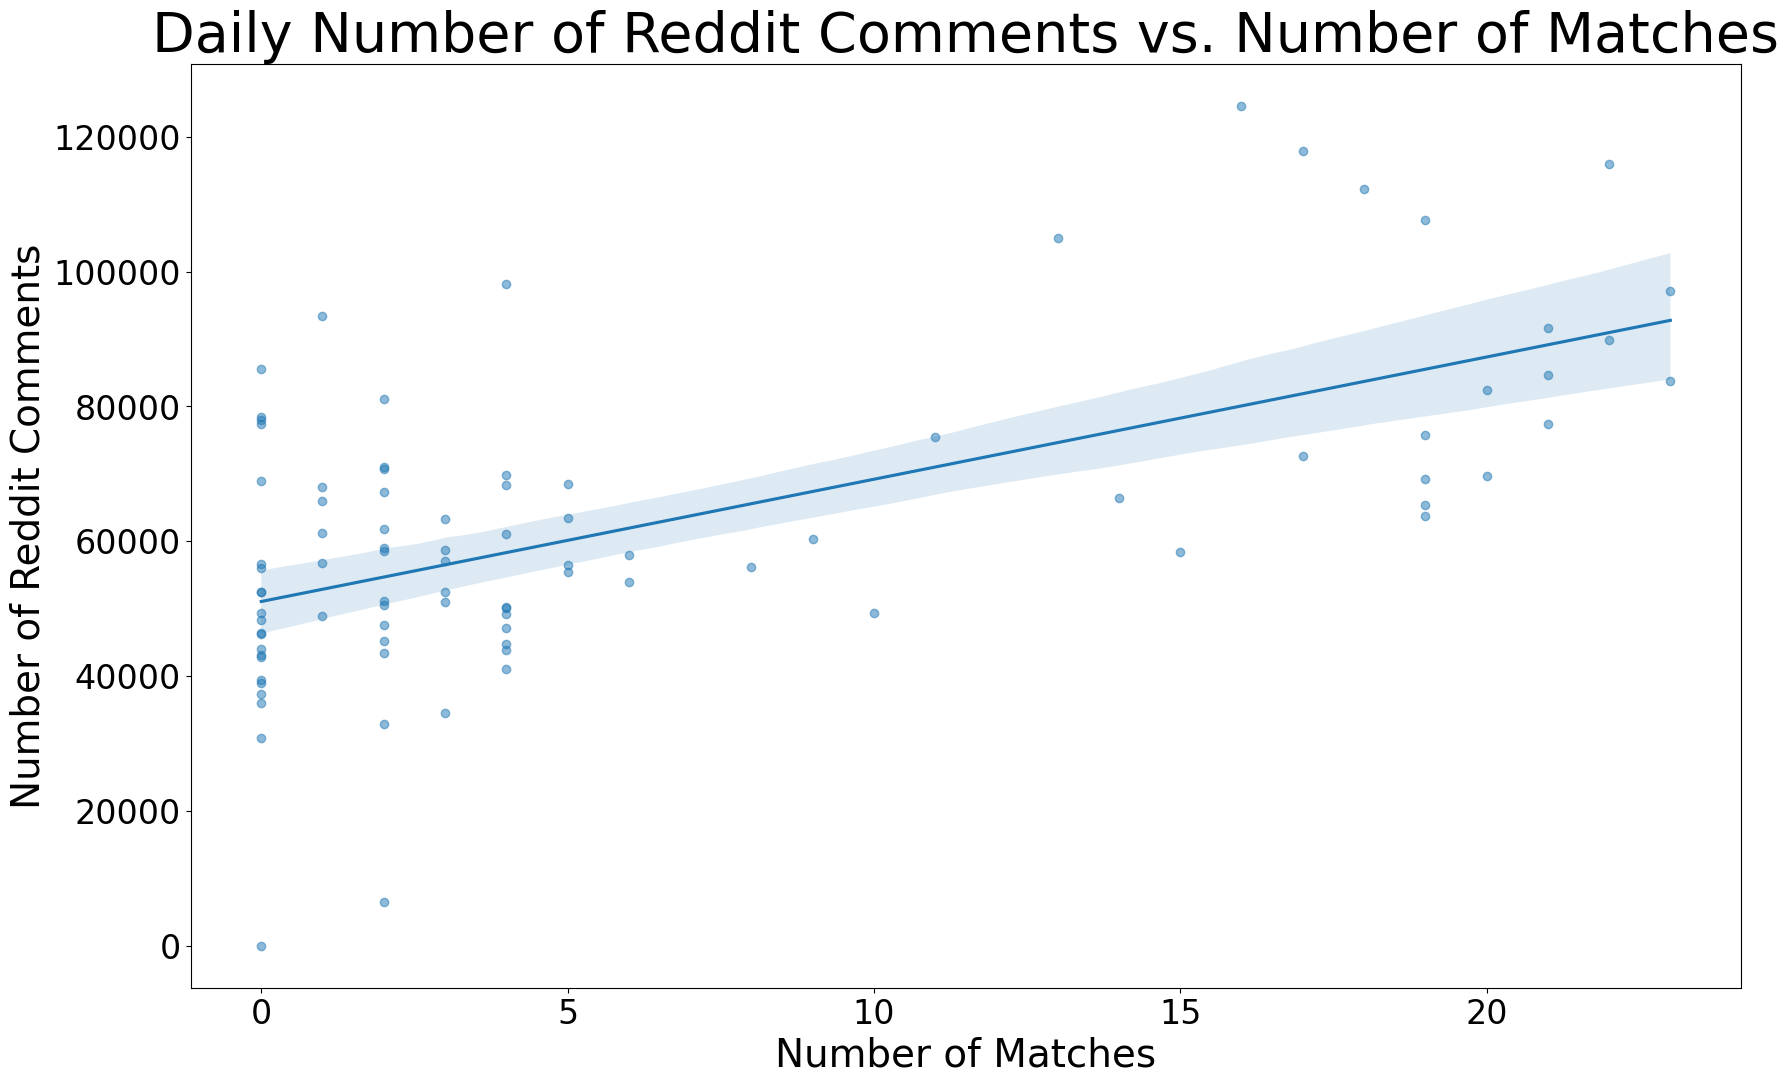

In [29]:
# Scatter plot with regression line
plt.figure(figsize=(20, 12))
sns.regplot(x='TotalMatches', y='count', data=merged_df, scatter_kws={'alpha':0.5})
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Number of Matches', fontsize=28)
plt.ylabel('Number of Reddit Comments', fontsize=28)
plt.title('Daily Number of Reddit Comments vs. Number of Matches', fontsize=40)

# Save the plot
plt.savefig('./daily_comments_matches_scatter.png')

plt.show()

Based on the scatter plot, the regression line shows that there is a positive relation between the number of matches and reddit comments per day, and the correlation is moderately strong.